# Data Preprocessing and Image Slicing for Mayo Clinic STRIP AI

## Overview
A key challenge in this competition is the highly varying dimensions of clot images. Rather than simply resizing—which can remove important spatial details—we implement an image slicing technique. This approach splits each image into fixed-size square patches (e.g., 512×512 or 256×256 pixels) and filters out patches that are nearly empty or non-informative.

## Objectives
- **Preserve Spatial Information:** Keep structural details intact by avoiding rough resizing.
- **Automated Filtering:** Discard slices with high mean intensity (indicative of non-informative regions) to focus on areas with valuable information.
- **Data Organization:** Structure the sliced patches into directories based on their original class labels (CE or LAA) for downstream training.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
from PIL import Image, ImageOps 
Image.MAX_IMAGE_PIXELS = 5000000000 
import os
import gc
import cv2
import torch
from torch import nn
import shutil
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from skimage import io
from tqdm import tqdm
import numpy as np

import warnings
warnings.filterwarnings("ignore")
gc.enable()

In [7]:
image = Image.open("../input/mayo-clinic-strip-ai/train/008e5c_0.tif")

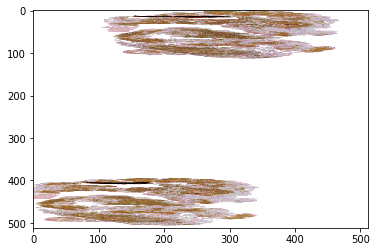

In [9]:
temp = np.asarray(image.resize((512,512)))
plt.imshow(temp, interpolation='nearest', aspect='auto')

In [2]:
df = pd.read_csv('/kaggle/input/mayo-clinic-strip-ai/train.csv')
df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [3]:
df.label.value_counts()

CE     547
LAA    207
Name: label, dtype: int64

In [4]:
j = 0
for i in list(df[df['label'] == 'CE'].index):
    df.drop(i,inplace=True)
    j += 1
    if j >( 547-207):
        break
df = df.sample(frac=1).reset_index(drop=True)
df.label.value_counts()

LAA    207
CE     206
Name: label, dtype: int64

## Image Slicing Function
The following function takes an input image and splits it into smaller square patches. It calculates the mean intensity of each patch and saves only those patches where the mean is below a threshold (relative to the original image's mean), ensuring that we only keep the informative regions.


In [5]:
!mkdir /kaggle/Clot_Dataset/
!mkdir /kaggle/Clot_Dataset/mayo-clinic
!mkdir /kaggle/Clot_Dataset/mayo-clinic/CE
!mkdir /kaggle/Clot_Dataset/mayo-clinic/LAA



In [6]:
path_CE = []
path_LAA = []
for i in range(len(df.image_id)):
    if df.label[i] == 'CE':        

        src = f"/kaggle/input/mayo-clinic-strip-ai/train/{df.image_id[i]}.tif"
        path_CE.append(src)
    if df.label[i] == 'LAA':
        
        src = f"/kaggle/input/mayo-clinic-strip-ai/train/{df.image_id[i]}.tif"
        path_LAA.append(src)


In [7]:
def store_data(new, j):    
    for i in tqdm(new):
        if i[:8] in list(df[df["label"]=='CE'].image_id):
            src = f"/kaggle/input/{j}/train/{i}"
            dst = f"/kaggle/Clot_Dataset/mayo-clinic/CE/{i}"
            img = Image.open(src)
            img_ar = np.array(img)
            mean = img_ar.mean()

            if (mean < 240) and (mean > 200):           
                shutil.copyfile(src, dst)
        elif i[:8] in list(df[df["label"]=='LAA'].image_id):
            src = f"/kaggle/input/{j}/train/{i}"
            dst = f"/kaggle/Clot_Dataset/mayo-clinic/LAA/{i}"
            img = Image.open(src)
            img_ar = np.array(img)
            mean = img_ar.mean()

            if (mean < 240) and( mean > 200):
                shutil.copyfile(src, dst)

In [8]:
data_list = os.listdir(f"/kaggle/input")

for j in data_list:
    if j == "mayo-clinic-strip-ai":
        pass
    else:
        new = os.listdir(f"/kaggle/input/{j}/train")
        print(j)
        store_data(new, j)

mayo-clinic-1024-jpg-part4-1


100%|██████████| 54978/54978 [10:02<00:00, 91.20it/s] 


mayo-clinic-1024-jpg-part5-1


100%|██████████| 63954/63954 [09:26<00:00, 112.84it/s]


mayo-clinic-1024-jpg-part9


100%|██████████| 47240/47240 [26:48<00:00, 29.37it/s]


mayo-clinic-1024-jpg-part6


100%|██████████| 72581/72581 [31:37<00:00, 38.26it/s] 


mayo-clinic-1024-jpg-part8


100%|██████████| 61567/61567 [35:43<00:00, 28.72it/s]


mayo-clinic-1024-jpg-part10


100%|██████████| 13757/13757 [07:55<00:00, 28.92it/s]


mayo-clinic-1024-jpg-part1


100%|██████████| 60090/60090 [10:34<00:00, 94.73it/s] 


mayo-clinic-1024-jpg-part7-1


100%|██████████| 64326/64326 [37:18<00:00, 28.73it/s]  


mayo-clinic-1024-jpg-part3


100%|██████████| 21762/21762 [03:19<00:00, 109.16it/s]


mayo-clinic-1024-jpg-part2-1


100%|██████████| 66899/66899 [13:16<00:00, 84.00it/s] 


In [9]:
!mkdir /root/.kaggle

In [10]:
cd /root/.kaggle

/root/.kaggle


## Data Organization & Export
After slicing the images, this section organizes the resulting patches into a structured folder format. Each class (CE and LAA) has its own directory, making it easier to load and use the data in model training notebooks.


In [13]:
import json

aDict = {"username":"medahmedkrichen","key":"e4d80ab73b1cc6e1ece8ed097b7d864a"}

jsonString = json.dumps(aDict)
jsonFile = open("/root/.kaggle/kaggle.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

In [14]:
import json

aDict = {  
         "title": "Clot_Dataset2", 
         "id": "medahmedkrichen/Clot-Dataset2", 
         "licenses": [{"name": "CC0-1.0"}]
}
jsonString = json.dumps(aDict)
jsonFile = open("/kaggle/Clot_Dataset/dataset-metadata.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

In [15]:
!chmod 600 /root/.kaggle/kaggle.json

In [16]:
%%capture
!zip -r /kaggle/Clot_Dataset/mayo-clinic.zip /kaggle/Clot_Dataset/mayo-clinic

In [17]:
!rm -r /kaggle/Clot_Dataset/mayo-clinic

In [18]:
!kaggle datasets create -p /kaggle/Clot_Dataset --dir-mode zip

Starting upload for file mayo-clinic.zip
100%|██████████████████████████████████████| 5.65G/5.65G [01:50<00:00, 54.8MB/s]
Upload successful: mayo-clinic.zip (6GB)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/datasets/medahmedkrichen/Clot-Dataset2


## Final Remarks
The data preprocessing and slicing pipeline described here is crucial for handling the challenges of variable image dimensions. The resulting dataset is now ready for effective model training. Future work could explore refining the slicing threshold or applying additional augmentations to further enhance data quality.


In [19]:
"""def slicing(image_path, window_size = 512, CE = True):
    img = Image.open(image_path)
    img_ar = np.array(img)
    genaral_mean = int(img_ar.mean())
    
    x_limit = img_ar.shape[0] // window_size
    y_limit = img_ar.shape[1] // window_size

    for i in range(x_limit):
        for j in range(y_limit):
            slice_ = img_ar[window_size*i:window_size*(i+1),window_size*j:window_size*(j+1),:]
            mean = slice_.mean()

            if mean < genaral_mean:
                im = Image.fromarray(slice_)
                im = ImageOps.grayscale(im)
                
                del slice_ 
                gc.collect()
                
                if CE:
                    im.save(f"/kaggle/train/CE/{image_path[-12:-4]}:{i}-{j}.jpeg")
                    
                    del im 
                    gc.collect()
                else:
                    im.save(f"/kaggle/train/LAA/{image_path[-12:-4]}:{i}-{j}.jpeg")
                    
                    del im 
                    gc.collect()
            else:
                del slice_ 
                gc.collect()

    del img_ar, img, x_limit, y_limit, mean, i, j, genaral_mean  
    gc.collect()"""

'def slicing(image_path, window_size = 512, CE = True):\n    img = Image.open(image_path)\n    img_ar = np.array(img)\n    genaral_mean = int(img_ar.mean())\n    \n    x_limit = img_ar.shape[0] // window_size\n    y_limit = img_ar.shape[1] // window_size\n\n    for i in range(x_limit):\n        for j in range(y_limit):\n            slice_ = img_ar[window_size*i:window_size*(i+1),window_size*j:window_size*(j+1),:]\n            mean = slice_.mean()\n\n            if mean < genaral_mean:\n                im = Image.fromarray(slice_)\n                im = ImageOps.grayscale(im)\n                \n                del slice_ \n                gc.collect()\n                \n                if CE:\n                    im.save(f"/kaggle/train/CE/{image_path[-12:-4]}:{i}-{j}.jpeg")\n                    \n                    del im \n                    gc.collect()\n                else:\n                    im.save(f"/kaggle/train/LAA/{image_path[-12:-4]}:{i}-{j}.jpeg")\n                    \n

In [20]:
"""window_size = 256

for i in path_CE:
    print(i+': \n')
    slicing(i, window_size = window_size, CE = True)
    gc.collect()
for i in tqdm(path_LAA):
    print(i+': \n')
    slicing(i, window_size = window_size, CE = False)
    gc.collect()"""

"window_size = 256\n\nfor i in path_CE:\n    print(i+': \n')\n    slicing(i, window_size = window_size, CE = True)\n    gc.collect()\nfor i in tqdm(path_LAA):\n    print(i+': \n')\n    slicing(i, window_size = window_size, CE = False)\n    gc.collect()"

In [21]:
"""fig, axes = plt.subplots(6,6, figsize=(20,20))
for i, ax in enumerate(axes.flat):
    img = io.imread("/kaggle/train/CE/"+sliced_train_images[i])
    ax.imshow(img); ax.set_title(i)
plt.tight_layout()
plt.show()"""

'fig, axes = plt.subplots(6,6, figsize=(20,20))\nfor i, ax in enumerate(axes.flat):\n    img = io.imread("/kaggle/train/CE/"+sliced_train_images[i])\n    ax.imshow(img); ax.set_title(i)\nplt.tight_layout()\nplt.show()'

In [22]:
"""for i in range(len(df.image_id)):
    if df.label[i] == 'CE':
        
        dst = f"/kaggle/train/CE/{df.image_id[i]}.tif"
        src = f"/kaggle/input/mayo-clinic-strip-ai/train/{df.image_id[i]}.tif"
        shutil.copyfile(src, dst)
    if df.label[i] == 'LAA':
        dst = f"/kaggle/train/LAA/{df.image_id[i]}.tif"
        src = f"/kaggle/input/mayo-clinic-strip-ai/train/{df.image_id[i]}.tif"
        shutil.copyfile(src, dst)"""

'for i in range(len(df.image_id)):\n    if df.label[i] == \'CE\':\n        \n        dst = f"/kaggle/train/CE/{df.image_id[i]}.tif"\n        src = f"/kaggle/input/mayo-clinic-strip-ai/train/{df.image_id[i]}.tif"\n        shutil.copyfile(src, dst)\n    if df.label[i] == \'LAA\':\n        dst = f"/kaggle/train/LAA/{df.image_id[i]}.tif"\n        src = f"/kaggle/input/mayo-clinic-strip-ai/train/{df.image_id[i]}.tif"\n        shutil.copyfile(src, dst)'